# Introducció a la pràctica 2



# Apartat (A): Comparativa de models (4pts)

L'objectiu d'aquest apartat és aprendre a comparar el rendiment obtingut amb els diferents models, utilitzant les mètriques adequades: precision-recall, accuracy, corba ROC, F1 score, etc... 

Es tracta d'ordenar per rendiment i descriure el per què dels resultats obtinguts amb els mètodes utilitzats en el següent apartat B.

A continuació us posem el codi bàsic per a una base de dades concreta, en el vostra cas haureu d'utilitzar la que se us ha assignat (veure la taula de dalt).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

# import some data to play with
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset('data/train.csv')

# Take the first two features. We could avoid this by using a two-dim dataset
data = dataset.values

X = data[:, :19]
y = data[:, 20]

X.shape


(2000, 19)

In [3]:
dataset.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Correct classification Logistic  0.5 % of the data:  0.645
Correct classification SVM       0.5 % of the data:  0.24
Correct classification Logistic  0.7 % of the data:  0.6333333333333333


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Correct classification SVM       0.7 % of the data:  0.23666666666666666
Correct classification Logistic  0.8 % of the data:  0.6475


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Correct classification SVM       0.8 % of the data:  0.2175


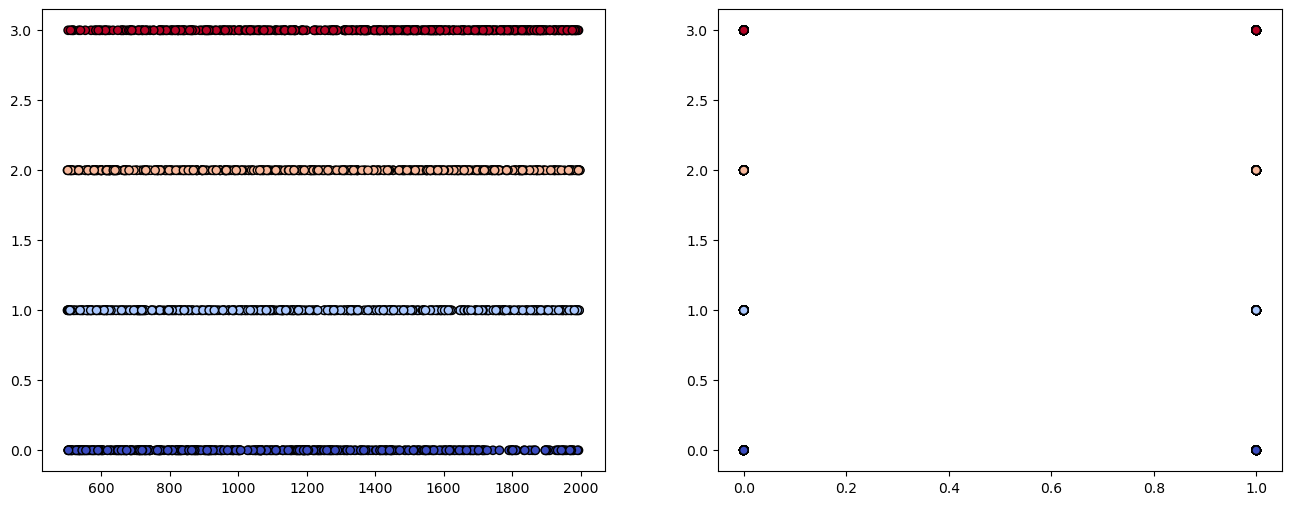

In [58]:
fig, sub = plt.subplots(1, 2, figsize=(16,6))
#Battery power
sub[0].scatter(X[:,0], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
#RAM
sub[1].scatter(X[:,1], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')


particions = [0.5, 0.7, 0.8]

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

    # l'entrenem
    logireg.fit(x_t, y_t)

    print ("Correct classification Logistic ", part, "% of the data: ", logireg.score(x_v, y_v))
    
    #Creem el regresor logístic
    svc = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True)

    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Correct classification SVM      ", part, "% of the data: ", svc.score(x_v, y_v))

Tal com podeu llegir a [l'API de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html), en comptes de fer una corba per cada classe, podem considerar totes les classes en conjunt en una sola corba (1 si hem predit la classe correcta, 0 si no). Això es coneix com a `micro-averaging`. 

Així, veureu que la funció `f1_score` utilitza el paràmetre `macro` per calcular la precision-recall-f1 per clase, i després fer la mitja pr a totes les classes; i `micro` per utilitzar totes les prediccions (i errors de FN, FP) per a calcular una única precision-recall-f1 per a totes les classes juntes.

Si voleu calcular la corba Precision-Recall quan utilitzeu el K-fold, cal calcular les corbes per a cada fold i després [fer la mitja de tots els folds per obtenir la corba final](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py). En el cas del LOOCV no té sentit fer la mitja la corba PR perquè hauriem de fer servir totes les mostres com a $y$.


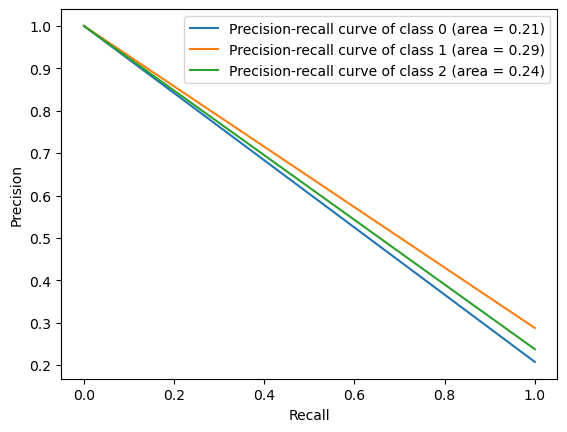

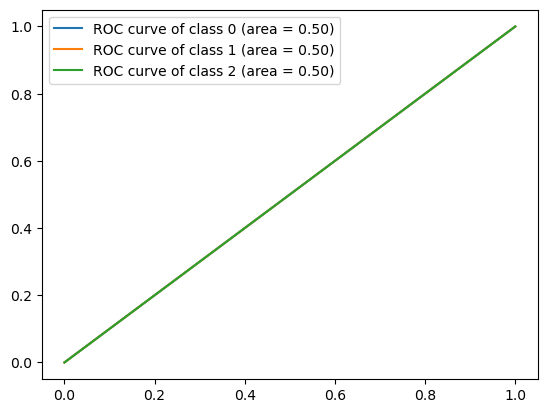

In [5]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
n_classes = 3
# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
    average_precision[i] = average_precision_score(y_v == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def show_C_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    dataset = load_dataset('data/train.csv')
    # Take the first two features. We could avoid this by using a two-dim dataset
    data = dataset.values

    X = data[:, [0, 13]]
    y = data[:, 20]
    X = Normalizer().fit(X).transform(X)
    
    
    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    titles = ('SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel')

    #C = 1.0  # SVM regularization parameter
    models = (svm.SVC(kernel='linear', C=C),
              svm.LinearSVC(C=C, max_iter=1000000),
              svm.SVC(kernel='rbf', gamma=gamma, C=C),
              svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C))
    models = (clf.fit(X, y) for clf in models)
    
    plt.close('all')
    fig, sub = plt.subplots(2, 2, figsize=(14,9))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

    


Podeu provar quin efecte té diferents valors de regularització per aquest petit exemple ( C=0.0001 to 1000..). També podeu veure com afecta els valors de degree i gamma. 

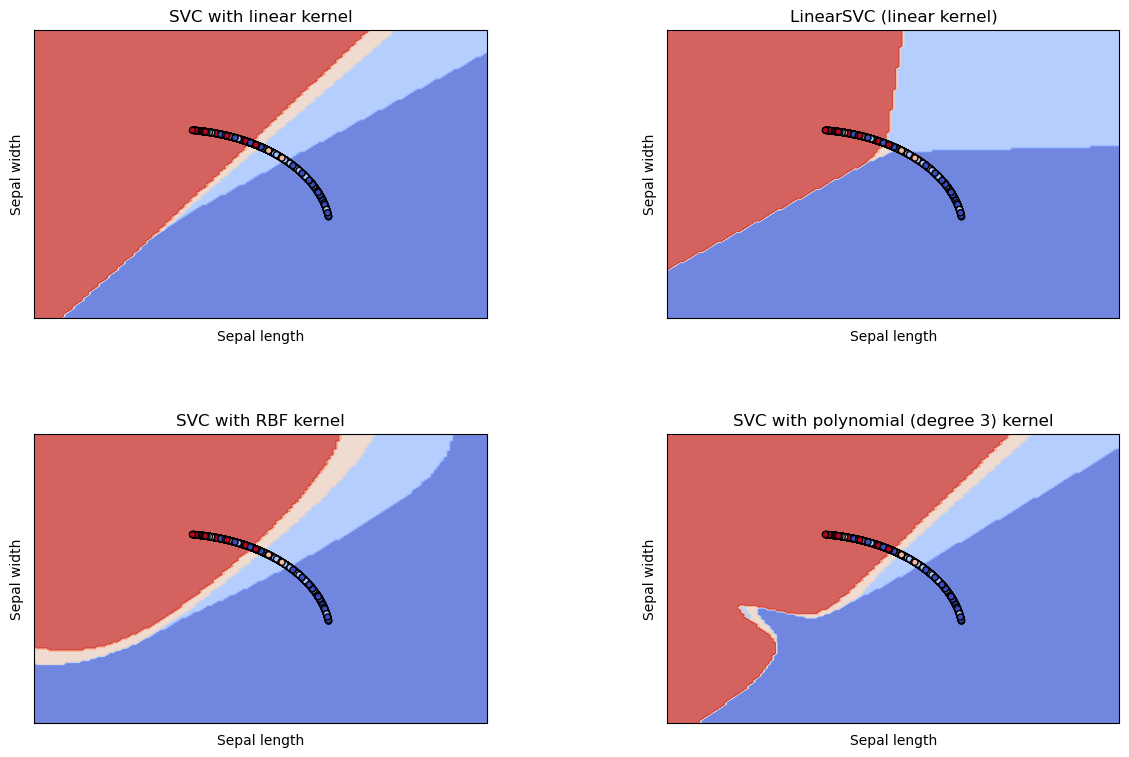

In [57]:
show_C_effect(0.1)

# Apartat (B): Classificació Numèrica (6pts)

Per a aquest primer apartat, s'analitzarà els tipus d'atributs que es tenen i, si no està estipulat, **caldrà fixar quin és l'atribut objectiu a classificar de tots els que hi ha a la base de dades**.
Expliqueu a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.

Treballarem varis aspectes de la classificació:

1. EDA (exploratory data analysis)
2. Preprocessing (normalitzation, outlier removal, feature selection..)
3. Model Selection
4. Crossvalidation
5. Metric Analysis
6. Hyperparameter Search


Durant els següents apartats, es recomana anar fent una taula amb el mètode, paràmetres i precisió obtinguda. D'aquesta manera serà més fàcil entendre i valorar què s'aconsegueix en cada metode. Exemple:

<img src="images/table_1.png" width="80%">

Les preguntes de cada apartat són orientatives. **NO** cal contestar-les totes, ni totes tindrán sentit per tots els datasets. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat. Tot i no ser obligatories, si que són molt recomenades d'intentar respondre.

### 1. EDA (exploratory data analysis)

Igual com a la pràctica anterior, exploreu i visualitzeu com és la base de dades que teniu assignada.

**Preguntes:**
* Quants atributs té la vostra base de dades?
* Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)
* Com es el target, quantes categories diferents existeixen?
* Podeu veure alguna correlació entre X i y?
* Estan balancejades les etiquetes (distribució similar entre categories)? Creus que pot afectar a la classificació la seva distribució?


In [62]:
dataset.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [63]:
dataset.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Text(0.5, 1.0, 'Correlation')

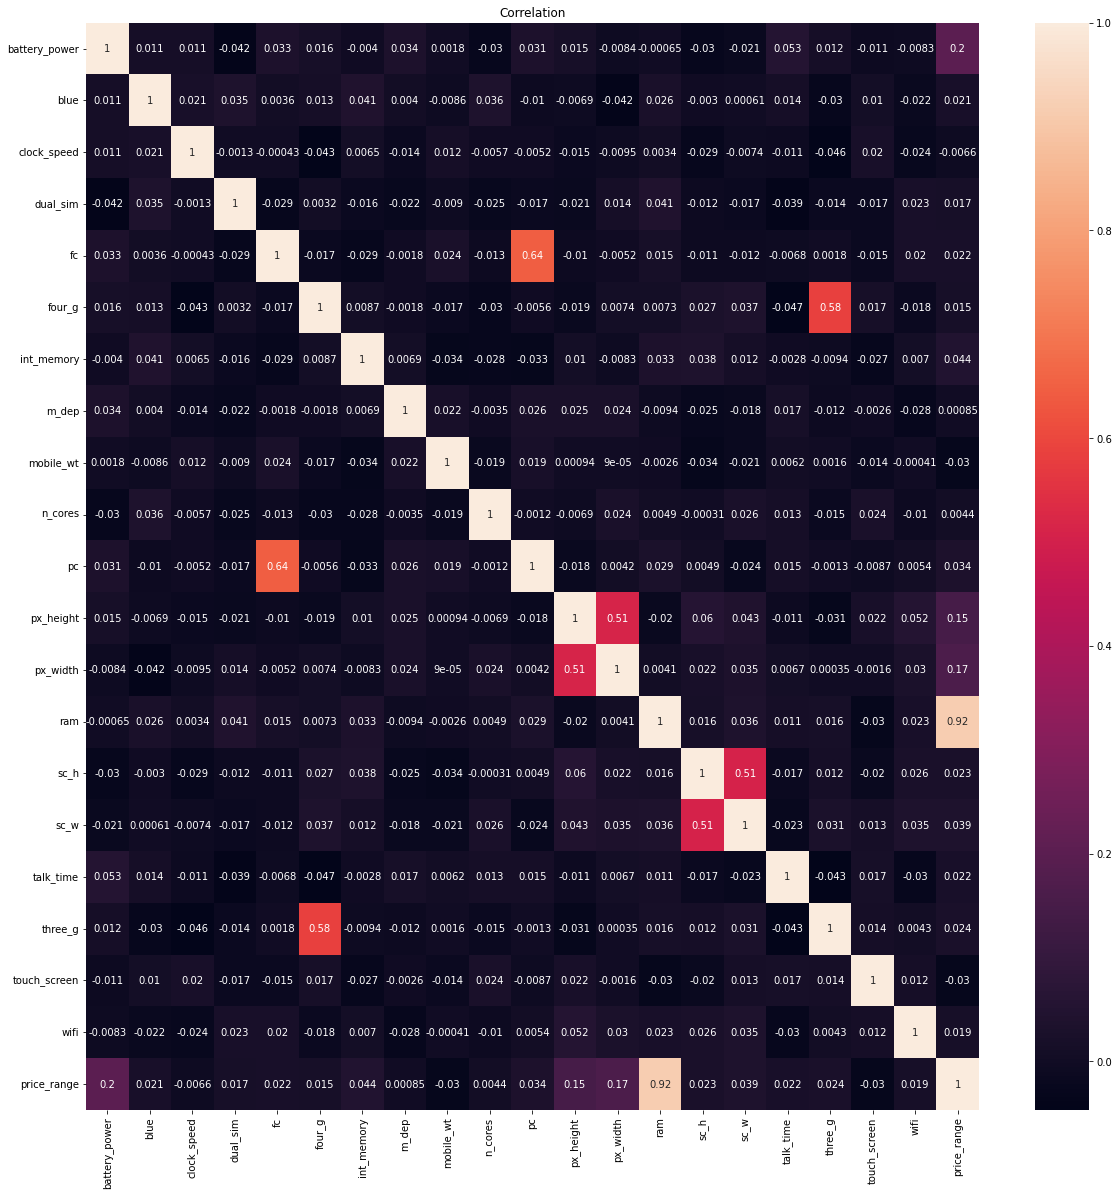

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
corr=dataset.corr()
fig = plt.figure(figsize=(20,20))
r = sns.heatmap(corr, annot=True)
r.set_title("Correlation")

In [64]:
#X = dataset.drop('price_range',axis=1)
#y = dataset['price_range']
X = data[:, [0,11,12,13]]
y = data[:, 20]

In [67]:
dataset['price_range'].unique()

array([1, 2, 3, 0])

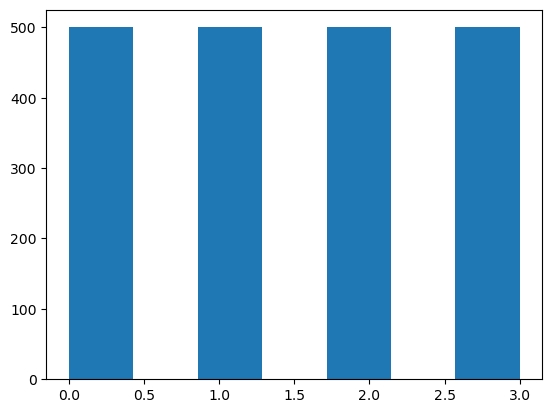

In [68]:
plt.hist(y, bins = 7)
plt.show()

### 2. Preprocessing (normalitzation, outlier removal, feature selection..)
Un cop vistes les dades de les que es disposa, per tal de tenir un aprenentatge més eficient, es recomana normalitzar les dades i treure outliers. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics..

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estàn les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització será més adient per les vostres dades?
* Teniu gaires dades sense informació? Els NaNs a pandas? Tingueu en compte que hi ha metodes que no els toleren durant el aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categoriques? Quina seria la codificació amb més sentit? (`OrdinalEncoder`, `OneHotEncoder`, d'altres?)
* Caldria aplicar `sklearn.decomposition.PCA`? Quins beneficis o inconvenients trobarieu?
* Es poden aplicar `PolynomialFeatures` per millorar la classificació? En quins casos té sentit fer-ho?

In [69]:
from sklearn.preprocessing import Normalizer

def normalize(X):
    transformer = Normalizer().fit(X)
    return transformer.transform(X)

X = normalize(X)

X

array([[0.30190459, 0.00717113, 0.27106873, 0.91396058],
       [0.28609688, 0.25359224, 0.55706229, 0.73723887],
       [0.1650721 , 0.37031272, 0.50313272, 0.76320191],
       ...,
       [0.47168627, 0.21424578, 0.40282156, 0.75454994],
       [0.79655097, 0.17701133, 0.35296902, 0.45780608],
       [0.12585702, 0.119194  , 0.18607096, 0.96712481]])

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.64652539 0.23359377]
[12.85222977  7.72531711]


In [71]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[1.        , 0.30190459, 0.00717113, ..., 0.00194387, 0.00655413,
        0.24774613],
       [1.        , 0.28609688, 0.25359224, ..., 0.14126667, 0.18695806,
        0.41068797],
       [1.        , 0.1650721 , 0.37031272, ..., 0.18631645, 0.28262338,
        0.38399185],
       ...,
       [1.        , 0.47168627, 0.21424578, ..., 0.08630282, 0.16165914,
        0.30394898],
       [1.        , 0.79655097, 0.17701133, ..., 0.06247951, 0.08103686,
        0.16159136],
       [1.        , 0.12585702, 0.119194  , ..., 0.02217854, 0.11527547,
        0.17995385]])

### 3. Model Selection
La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de varies tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist varies tècniques, com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour, i el perceptró...
En aquesta secció heu de valorar quina o quines tècniques voleu fer servir, aixi com també explicar el per què les heu seleccionat. Recomanem, que per entendre millor la teoria, s'ha de provar com a mínim un model de SVM.

**Preguntes:**
* Quins models heu considerat?
* Considereu les SVM amb els diferents kernels implementats.
* Quin creieu que serà el més precís?
* Quin serà el més ràpid?
* Seria una bona idea fer un `ensemble`? Quins inconvenients creieu que pot haver-hi? [Documentació](https://scikit-learn.org/stable/modules/ensemble.html)

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier

x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.8)

def logisticRegression(x_t, x_v, y_t, y_v):
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

    # l'entrenem
    logireg.fit(x_t, y_t)
    print ("Correct classification Logistic : ", logireg.score(x_v, y_v))

def SVC(x_t, x_v, y_t, y_v, svc_kernel):
    #Creem el regresor logístic
    svc = svm.SVC(C=1.0, kernel=svc_kernel, gamma=0.9, probability=True)

    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Correct classification SVM " , svc_kernel , " ", svc.score(x_v, y_v))

def knn(x_t, x_v, y_t, y_v, numbers_neighbors):
    neigh = KNeighborsClassifier(n_neighbors=numbers_neighbors)
    neigh.fit(x_t, y_t)
    prob = neigh.predict(x_v)
    print ("Correct classification KNN: " , numbers_neighbors, " ", neigh.score(x_v, y_v))

def perceptron(x_t, x_v, y_t, y_v):
    clf = Perceptron(penalty='l2')
    clf.fit(x_t, y_t)
    print ("Correct classification Perceptron: ", clf.score(x_v, y_v))
           
def ensembleRandomForestClassifier(x_t, x_v, y_t, y_v):
    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(x_t, y_t)
    print ("Correct classification RandomForestClassifier: ", clf.score(x_v, y_v))


In [73]:
logisticRegression(x_t, x_v, y_t, y_v)
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
SVC(x_t, x_v, y_t, y_v, 'linear')
SVC(x_t, x_v, y_t, y_v, 'poly')
SVC(x_t, x_v, y_t, y_v, 'rbf')
SVC(x_t, x_v, y_t, y_v, 'sigmoid')
for k in range(1, 10):
    knn(x_t, x_v, y_t, y_v, k)

perceptron(x_t, x_v, y_t, y_v)
ensembleRandomForestClassifier(x_t, x_v, y_t, y_v)

Correct classification Logistic :  0.53
Correct classification SVM  linear   0.5275
Correct classification SVM  poly   0.58
Correct classification SVM  rbf   0.5675
Correct classification SVM  sigmoid   0.4975
Correct classification KNN:  1   0.4925
Correct classification KNN:  2   0.495
Correct classification KNN:  3   0.53
Correct classification KNN:  4   0.5125
Correct classification KNN:  5   0.5325
Correct classification KNN:  6   0.52
Correct classification KNN:  7   0.53
Correct classification KNN:  8   0.5375
Correct classification KNN:  9   0.535
Correct classification Perceptron:  0.4525
Correct classification RandomForestClassifier:  0.525


In [ ]:
# SVC POLY Y RBF, LOGISTIC, KNN 5, RandomForestClassifier

### 4. Crossvalidation
Un cop seleccionats quins models es volen testejar sobre les dades, s'han de poder evaluar correctament. Per aquests motius, haurem d'aprendre a cros-validar els resultats.
Reviseu la [documentació](https://scikit-learn.org/stable/modules/cross_validation.html) i escolliu quin tipus de crossvalidació pot ser l'adecuada pel vostre problema.

**Preguntes:**
* Per què és important cross-validar els resultats?
* Separa la base de dades en el conjunt de train-test. Com de fiables serán els resultats obtinguts? En quins casos serà més fiable, si tenim moltes dades d'entrenament o poques?
* Quin tipus de K-fold heu escollit? Quants conjunts heu seleccionat (quina k)? Com afecta els diferents valors de k?
* Es viable o convenient aplicar `LeaveOneOut`?


In [77]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold

def kfold(X, y):
    for i in range(2, 4):
        kf = KFold(n_splits=i)
        print("Number of splits", kf.get_n_splits(X))
        for train, test in kf.split(X):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            logisticRegression(X_test, X_train, y_test, y_train)
            knn(X_test, X_train, y_test, y_train, 5)
            SVC(X_test, X_train, y_test, y_train, 'poly')
            SVC(X_test, X_train, y_test, y_train, 'rbf')
            ensembleRandomForestClassifier(X_test, X_train, y_test, y_train)
            

def repeatedKFold(X, y):
        rkf = RepeatedKFold(n_splits=2)
        print("Number of splits", rkf.get_n_splits(X))
        for train, test in rkf.split(X):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            logisticRegression(X_test, X_train, y_test, y_train)
            knn(X_test, X_train, y_test, y_train, 5)
            SVC(X_test, X_train, y_test, y_train, 'poly')
            SVC(X_test, X_train, y_test, y_train, 'rbf')
            ensembleRandomForestClassifier(X_test, X_train, y_test, y_train)
          
        
def stratifiedKFold(X, y):
    
        skf = StratifiedKFold(n_splits=2)
        print("Number of splits", skf.get_n_splits(X, y))
        for train, test in skf.split(X, y):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            
            logisticRegression(X_test, X_train, y_test, y_train)
            knn(X_test, X_train, y_test, y_train, 5)
            SVC(X_test, X_train, y_test, y_train, 'poly')
            SVC(X_test, X_train, y_test, y_train, 'rbf')
            ensembleRandomForestClassifier(X_test, X_train, y_test, y_train)
            


kfold(X, y)
print("==============")
repeatedKFold(X, y)
print("==============")
stratifiedKFold(X, y)

Number of splits 2
Correct classification Logistic :  0.523
Correct classification KNN:  5   0.523
Correct classification SVM  poly   0.536
Correct classification SVM  rbf   0.531
Correct classification RandomForestClassifier:  0.549
Correct classification Logistic :  0.521
Correct classification KNN:  5   0.505
Correct classification SVM  poly   0.569
Correct classification SVM  rbf   0.563
Correct classification RandomForestClassifier:  0.516
Number of splits 3
Correct classification Logistic :  0.5326331582895724
Correct classification KNN:  5   0.5206301575393848
Correct classification SVM  poly   0.5536384096024006
Correct classification SVM  rbf   0.5461365341335334
Correct classification RandomForestClassifier:  0.5326331582895724
Correct classification Logistic :  0.522880720180045
Correct classification KNN:  5   0.5063765941485371
Correct classification SVM  poly   0.5431357839459865
Correct classification SVM  rbf   0.5341335333833458
Correct classification RandomForestClass

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Correct classification SVM  rbf   0.554
Correct classification RandomForestClassifier:  0.522
Correct classification Logistic :  0.527
Correct classification KNN:  5   0.501
Correct classification SVM  poly   0.548
Correct classification SVM  rbf   0.542
Correct classification RandomForestClassifier:  0.528
Correct classification Logistic :  0.523
Correct classification KNN:  5   0.507
Correct classification SVM  poly   0.544
Correct classification SVM  rbf   0.544
Correct classification RandomForestClassifier:  0.492
Correct classification Logistic :  0.513
Correct classification KNN:  5   0.5
Correct classification SVM  poly   0.559
Correct classification SVM  rbf   0.553
Correct classification RandomForestClassifier:  0.515
Correct classification Logistic :  0.527
Correct classification KNN:  5   0.513
Correct classification SVM  poly   0.542
Correct classification SVM  rbf   0.541
Correct classification RandomForestClassifier:  0.503
Correct classification Logistic :  0.535
Correct

### 5. Metric Analysis
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)).

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`.
* Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre [Pista](https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc)
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

In [83]:
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.8)

In [100]:
from sklearn.metrics import accuracy_score

def getPredictlogisticRegression(x_t, x_v, y_t, y_v, proba=False):
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)
    # l'entrenem
    logireg.fit(x_t, y_t)
    if proba:
        return logireg.predict_proba(x_v)
    
    return logireg.predict(x_v)
    
def getPredictSVC(x_t, x_v, y_t, y_v, svc_kernel, proba=False):
    svc = svm.SVC(C=1.0, kernel=svc_kernel, gamma=0.9, probability=True)
    svc.fit(x_t, y_t)
    if proba:
        return svc.predict_proba(x_v)
    
    return svc.predict(x_v)

def getPredictknn(x_t, x_v, y_t, y_v, numbers_neighbors, proba=False):
    neigh = KNeighborsClassifier(n_neighbors=numbers_neighbors)
    neigh.fit(x_t, y_t)
    if proba:
        return neigh.predict_proba(x_v)
    
    return neigh.predict(x_v)
           
def getPredictensembleRandomForestClassifier(x_t, x_v, y_t, y_v, proba=False):
    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(x_t, y_t)
    if proba:
        return clf.predict_proba(x_v)
    
    return clf.predict(x_v)


y_pred_lg = getPredictlogisticRegression(x_t, x_v, y_t, y_v)


y_pred_svc_poly = getPredictSVC(x_t, x_v, y_t, y_v, 'poly')
y_pred_svc_rbf = getPredictSVC(x_t, x_v, y_t, y_v, 'rbf')
y_pred_knn = getPredictknn(x_t, x_v, y_t, y_v, 5)
y_pred_ensembleRFC = getPredictensembleRandomForestClassifier(x_t, x_v, y_t, y_v)

y_pred_proba_lg = getPredictlogisticRegression(x_t, x_v, y_t, y_v, True)
y_pred_proba_svc_poly = getPredictSVC(x_t, x_v, y_t, y_v, 'poly', True)
y_pred_proba_svc_rbf = getPredictSVC(x_t, x_v, y_t, y_v, 'rbf', True)
y_pred_proba_knn = getPredictknn(x_t, x_v, y_t, y_v, 5, True)
y_pred_proba_ensembleRFC = getPredictensembleRandomForestClassifier(x_t, x_v, y_t, y_v, True)

print("======= Accuracy score ==========")
print("Accuracy score of Logistic Regression: ", accuracy_score(y_v, y_pred_lg))
print("Accuracy score of SVC POLY: ", accuracy_score(y_v, y_pred_svc_poly))
print("Accuracy score of SVC RBF: ", accuracy_score(y_v, y_pred_svc_rbf))
print("Accuracy score of KNN 5: ", accuracy_score(y_v, y_pred_knn))
print("Accuracy score of ensemble RFC: ", accuracy_score(y_v, y_pred_ensembleRFC))
print("======= F1 score ==========")
print("F1 score of Logistic Regression: ", f1_score(y_v, y_pred_lg, average='micro'))
print("F1 score of SVC POLY: ", f1_score(y_v, y_pred_svc_poly, average='micro'))
print("F1 score of SVC RBF: ", f1_score(y_v, y_pred_svc_rbf, average='micro'))
print("F1 score of KNN 5: ", f1_score(y_v, y_pred_knn, average='micro'))
print("F1 score of ensemble RFC: ", f1_score(y_v, y_pred_ensembleRFC, average='micro'))
print("======= average_precision_score ==========")
#print("Accuracy score of Logistic Regression: ", average_precision_score(y_v, y_pred_proba_lg, average='micro'))
#print("Accuracy score of SVC POLY: ", average_precision_score(y_v, y_pred_proba_svc_poly))
#print("Accuracy score of SVC RBF: ", average_precision_score(y_v, y_pred_proba_svc_rbf))
#print("Accuracy score of KNN 5: ", average_precision_score(y_v, y_pred_proba_knn))
#print("Accuracy score of ensemble RFC: ", average_precision_score(y_v, y_pred_proba_ensembleRFC))

[1. 0. 1. 3. 2. 2. 3. 3. 0. 0. 3. 0. 2. 3. 3. 1. 0. 0. 0. 1. 0. 1. 2. 0.
 2. 3. 2. 3. 3. 1. 3. 3. 3. 0. 3. 0. 1. 2. 0. 3. 3. 3. 0. 3. 0. 3. 0. 2.
 2. 0. 0. 3. 1. 1. 3. 2. 2. 3. 3. 0. 2. 3. 3. 3. 3. 0. 2. 3. 0. 2. 0. 1.
 3. 0. 3. 3. 1. 1. 1. 3. 1. 3. 0. 1. 3. 3. 3. 1. 3. 3. 3. 1. 3. 2. 0. 3.
 0. 0. 1. 0. 0. 3. 3. 1. 3. 2. 1. 2. 3. 1. 0. 2. 0. 3. 1. 1. 2. 3. 0. 2.
 3. 1. 3. 1. 0. 3. 0. 3. 3. 2. 3. 0. 0. 2. 2. 1. 0. 1. 0. 1. 0. 3. 1. 1.
 3. 0. 1. 0. 2. 2. 3. 1. 3. 1. 0. 3. 0. 3. 2. 2. 2. 3. 3. 2. 1. 3. 0. 0.
 1. 1. 0. 0. 3. 2. 0. 3. 2. 3. 0. 3. 0. 3. 1. 1. 3. 3. 3. 0. 0. 1. 1. 1.
 3. 0. 1. 3. 0. 3. 3. 0. 2. 0. 1. 3. 3. 1. 3. 3. 1. 1. 3. 3. 3. 3. 3. 2.
 3. 3. 3. 0. 3. 0. 3. 2. 1. 3. 0. 1. 1. 1. 3. 2. 3. 2. 1. 3. 3. 1. 3. 3.
 2. 1. 3. 1. 0. 3. 1. 3. 3. 3. 0. 3. 1. 2. 0. 2. 3. 3. 1. 3. 0. 3. 3. 2.
 3. 1. 1. 1. 1. 0. 3. 0. 0. 3. 0. 2. 1. 0. 0. 1. 2. 3. 3. 2. 1. 0. 0. 0.
 0. 3. 3. 1. 0. 1. 3. 0. 0. 3. 3. 1. 0. 0. 0. 0. 3. 3. 3. 2. 0. 1. 3. 2.
 3. 2. 2. 1. 2. 3. 0. 3. 3. 0. 3. 0. 3. 2. 1. 0. 0.

ValueError: multiclass format is not supported

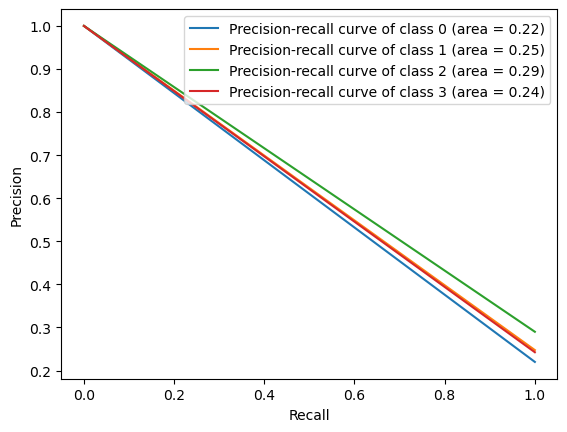

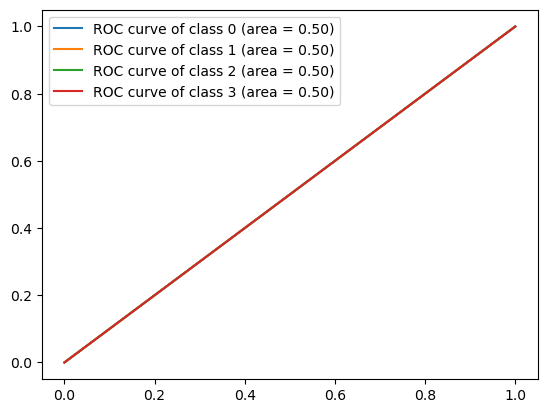

In [81]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

n_classes = 4
# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
    average_precision[i] = average_precision_score(y_v == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

### 6. Hyperparameter Search
El motiu d'aplicar crossvalidació durant l'entrenament és que ens permet conèixer quin serà el resultat esperat del nostre model un cop en producció, és a dir, com es comportarà sobre dades mai vistes abans.
A més, també ens permet optimitzar quins són els hiperparametres dels models que millor funcionaran en el futur test.

**Preguntes:**
* Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html)
* Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels dos métodes creieu que obtindrà millor resultat final?
* Existeixen altres mètodes de búsqueda més eficients ([scikit-optimize](https://scikit-optimize.github.io/stable/))?
* Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (estimeu el temps que trigarà a fer 1 training, i aixi trobeu el número de intents que podeu fer en cada cas.)

